In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual

# Define some helper functions

In [2]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def cross_validate(x,y):
    from sklearn.model_selection import cross_validate
    clf1 = LogisticRegression(random_state=1, class_weight='balanced')
    clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf3 = GaussianNB()
    clf4 = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clf5 = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(random_state=42, n_components=2), KNeighborsClassifier(n_neighbors=2))
    clf6 = make_pipeline(StandardScaler(), SVC(kernel='poly',gamma='auto',class_weight='balanced', C=1, degree=3))
    clf7 = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
    
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 16})

    eclf = VotingClassifier(
        estimators=[
            #('lr', clf1), ('rf', clf2), ('gnb', clf3), 
            ('rf', clf2), ('svc', clf6)
                   ],
        voting='hard')
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'scaled DecissionTree', 'KNN', 'scaled SVC(poly)', 'SVC(poly)', 'Ensemble']):
        y_pred = cross_val_predict(clf, x, y, cv=5)
        scores = cross_validate(clf, x, y, scoring=['recall', 'accuracy'], cv=5)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        i = i + 1
    plt.show()

# Read the dmd dataframe with all timesteps

In [4]:
df_strain_comp = pd.read_csv('/mnt/ssd/git/dynamic-cmr-models/data/predicted/df_DMD_time_v16_comp.csv')
df_strain_p2p = pd.read_csv('/mnt/ssd/git/dynamic-cmr-models/data/predicted/df_DMD_time_v16_p2p.csv')
df_strain_comp.sort_values(by=['pat', 'aha'], inplace=True)
df_strain_p2p.sort_values(by=['pat', 'aha'], inplace=True)

In [5]:
print(df_strain_comp[df_strain_comp.isna().any(axis=1)])
print(df_strain_p2p[df_strain_p2p.isna().any(axis=1)])

Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []


In [6]:
print(df_strain_comp.shape)
print(df_strain_p2p.shape)

(4480, 7)
(4480, 7)


In [7]:
df_strain_comp.head()

,pat,aha,phase,our_rs,our_cs,soa,lge
0,aa_20180710,1,0,0.915333,0.177148,0,0
1,aa_20180710,1,1,0.930618,0.226990,0,0
2,aa_20180710,1,2,0.596300,0.108193,0,0
3,aa_20180710,1,3,0.220566,0.043842,0,0
4,aa_20180710,1,4,0.005196,-0.000394,0,0


In [8]:
#df_strain_t = df_strain_t[~df_strain_t['pat'].isin(['ge_20190917', 'hb_20191227', 'rc_20181207', 'rg_20180919','sj_20180730'])]

# Phase in which min(CS) und max(rs) occures

Phases: [0:4] --> ED,MS,ES,PF,MD
Usually min(cs) and max(rs) should reflect the phase MS--> ES, which sould be phase==1

# Distribution of RS and CS per phase grouped by lge positive/negative class

******************** strain composed ********************


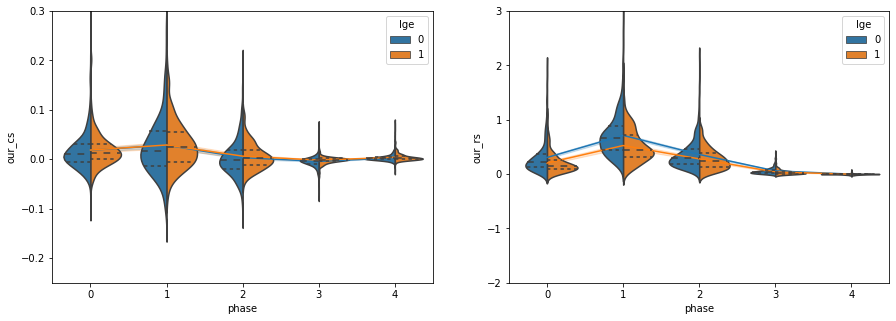

******************** strain p2p ********************


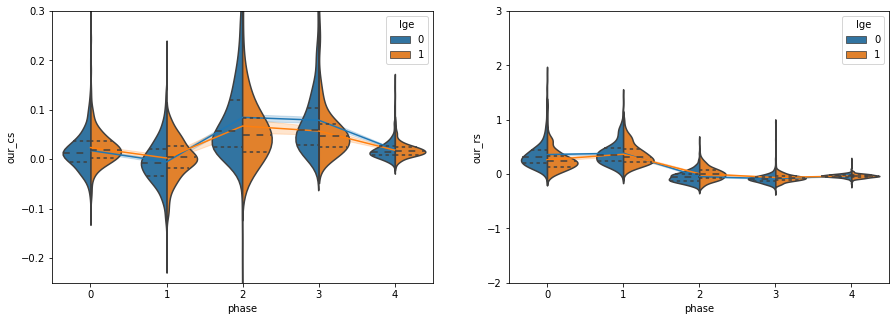

In [9]:
def plot_strain_per_time(df):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                 hue="lge",err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, split=True,hue='lge')
    ax1.set_ylim((-0.25, 0.3))
    

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue="lge",err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, split=True,hue='lge')

    ax2.set_ylim((-2, 3.))
    plt.show()
    
print('*'*20,'strain composed','*'*20)
plot_strain_per_time(df_strain_comp)
print('*'*20,'strain p2p','*'*20)
plot_strain_per_time(df_strain_p2p)

# Identify pcs und prs 
- by max/min or by 
- a pre-defined phase (eg.: ES)

In [10]:
def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df_strain_comp.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df_strain_comp.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

# peak radial and circumferential strain
# for the composed and p2p strain values
prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)
    
# 56 patients x 16 segments = 896 --> Peak strain per patient and segment

df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

# composed phase
df_peak['prs_com_p']=prs_com_p
df_peak['pcs_com_p']=pcs_com_p
# composed arg-min/max
df_peak['prs_com_arg']=prs_com_arg
df_peak['pcs_com_arg']=pcs_com_arg
# p2p phase
df_peak['prs_p2p_p']=prs_p2p_p
df_peak['pcs_p2p_p']=pcs_p2p_p
# p2p arg-min/max
df_peak['prs_p2p_arg']=prs_p2p_arg
df_peak['pcs_p2p_arg']=pcs_p2p_arg

df_peak.drop(labels='phase', axis=1, inplace=True)
df_peak.drop(labels='our_rs', axis=1, inplace=True)
df_peak.drop(labels='our_cs', axis=1, inplace=True)
df_peak.sort_values(by=['pat', 'aha'], inplace=True)
print(df_peak.shape)



(896, 12)


In [11]:
temp_y = np.stack(df_strain_comp.groupby(['phase'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(5, 896)
LGE positive patients:  176
LGE negative patients:  720


In [12]:
temp_y = np.stack(df_strain_comp.groupby(['phase','aha'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(80, 56)
LGE positive patients:  32
LGE negative patients:  24


In [13]:
temp_y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive segments: ',(temp_y==True).sum())
print('LGE negative segments: ',(temp_y==False).sum())
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 80)
LGE positive segments:  880
LGE negative segments:  3600
LGE positive patients:  32
LGE negative patients:  24


In [14]:
temp_y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 16)
LGE positive patients:  32
LGE negative patients:  24


In [15]:
df_peak = df_peak.apply(lambda x: x.astype(float, errors='ignore'), axis=0)
df_peak.dtypes

pat             object
aha            float64
soa            float64
lge            float64
prs_com_p      float64
pcs_com_p      float64
prs_com_arg    float64
pcs_com_arg    float64
prs_p2p_p      float64
pcs_p2p_p      float64
prs_p2p_arg    float64
pcs_p2p_arg    float64
dtype: object

# which phase has maximal/minimal radial/circumferential strain values

******************** strain composed ********************


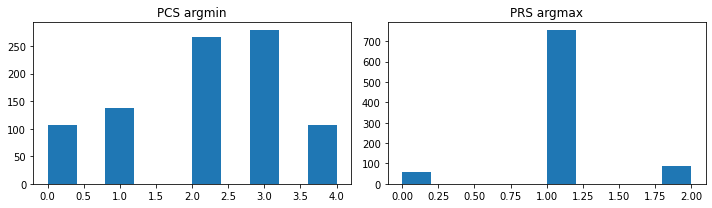

******************** strain p2p ********************


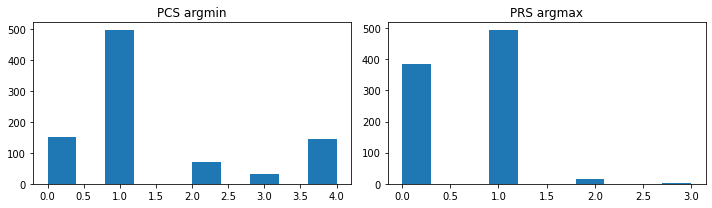

In [16]:
def show_phase_with_max_min_strain(df):
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    # peak radial strain
    rs = np.stack(df.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32)
    # peak circumferential strain
    cs = np.stack(df.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)

    prs_argmax = np.argmax(rs, axis=1)
    pcs_argmin = np.argmin(cs, axis=1)

    # plot
    ax[0].hist(pcs_argmin)
    ax[0].set_title('PCS argmin')
    ax[1].hist(prs_argmax)
    ax[1].set_title('PRS argmax')
    plt.tight_layout()
    plt.show()
    
print('*'*20,'strain composed','*'*20)
show_phase_with_max_min_strain(df_strain_comp)
print('*'*20,'strain p2p','*'*20)
show_phase_with_max_min_strain(df_strain_p2p)

# Pairplot composed strain values

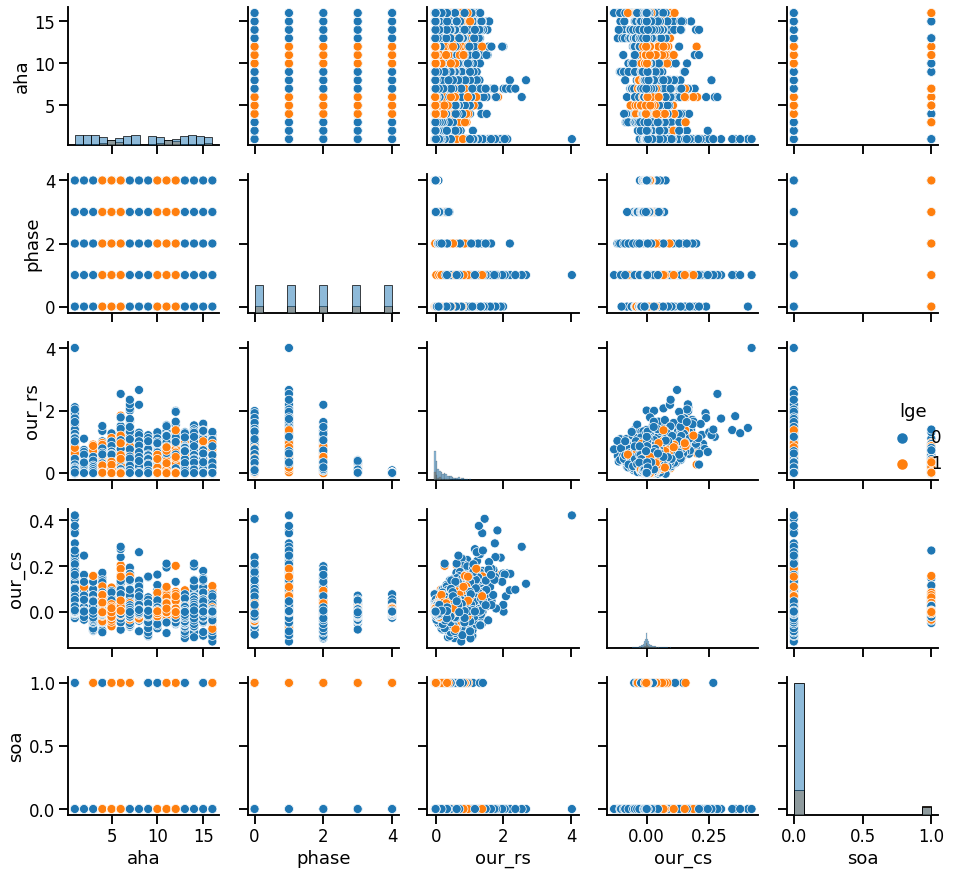

In [17]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_comp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

# Pairplot p2p strain values

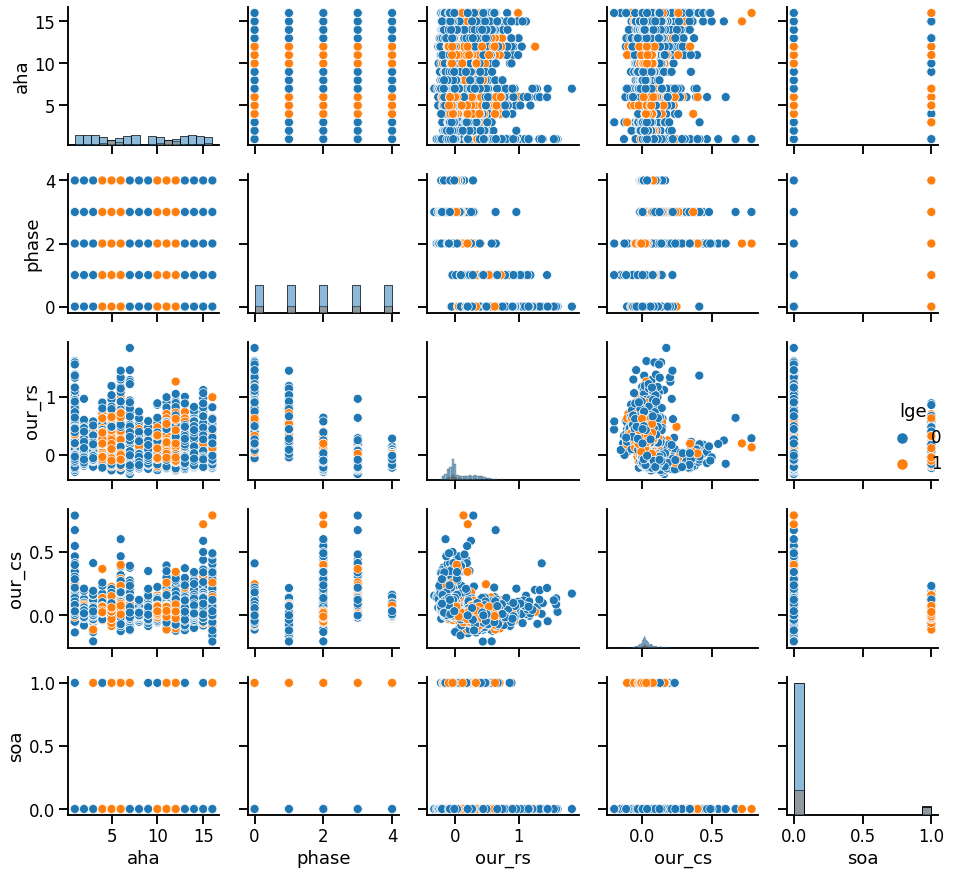

In [18]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_p2p,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

In [19]:
df_peak.head()

,pat,aha,soa,lge,prs_com_p,pcs_com_p,prs_com_arg,pcs_com_arg,prs_p2p_p,pcs_p2p_p,prs_p2p_arg,pcs_p2p_arg
0,aa_20180710,1.0,0.0,0.0,0.930618,0.226990,0.930618,-0.000394,0.940246,0.045605,0.930618,-0.000394
5,aa_20180710,2.0,0.0,0.0,0.647063,0.075693,0.647063,0.000396,0.313685,0.039412,0.647063,0.000396
10,aa_20180710,3.0,0.0,0.0,0.193750,-0.026550,0.193750,-0.026550,0.149145,-0.026990,0.193750,-0.026550
15,aa_20180710,4.0,0.0,0.0,0.301456,0.009213,0.301456,-0.002673,0.387614,0.124339,0.301456,-0.002673
20,aa_20180710,5.0,0.0,0.0,0.540337,0.040706,0.540338,-0.004024,0.744522,0.057000,0.540338,-0.004024


# Pairplot peak strain values

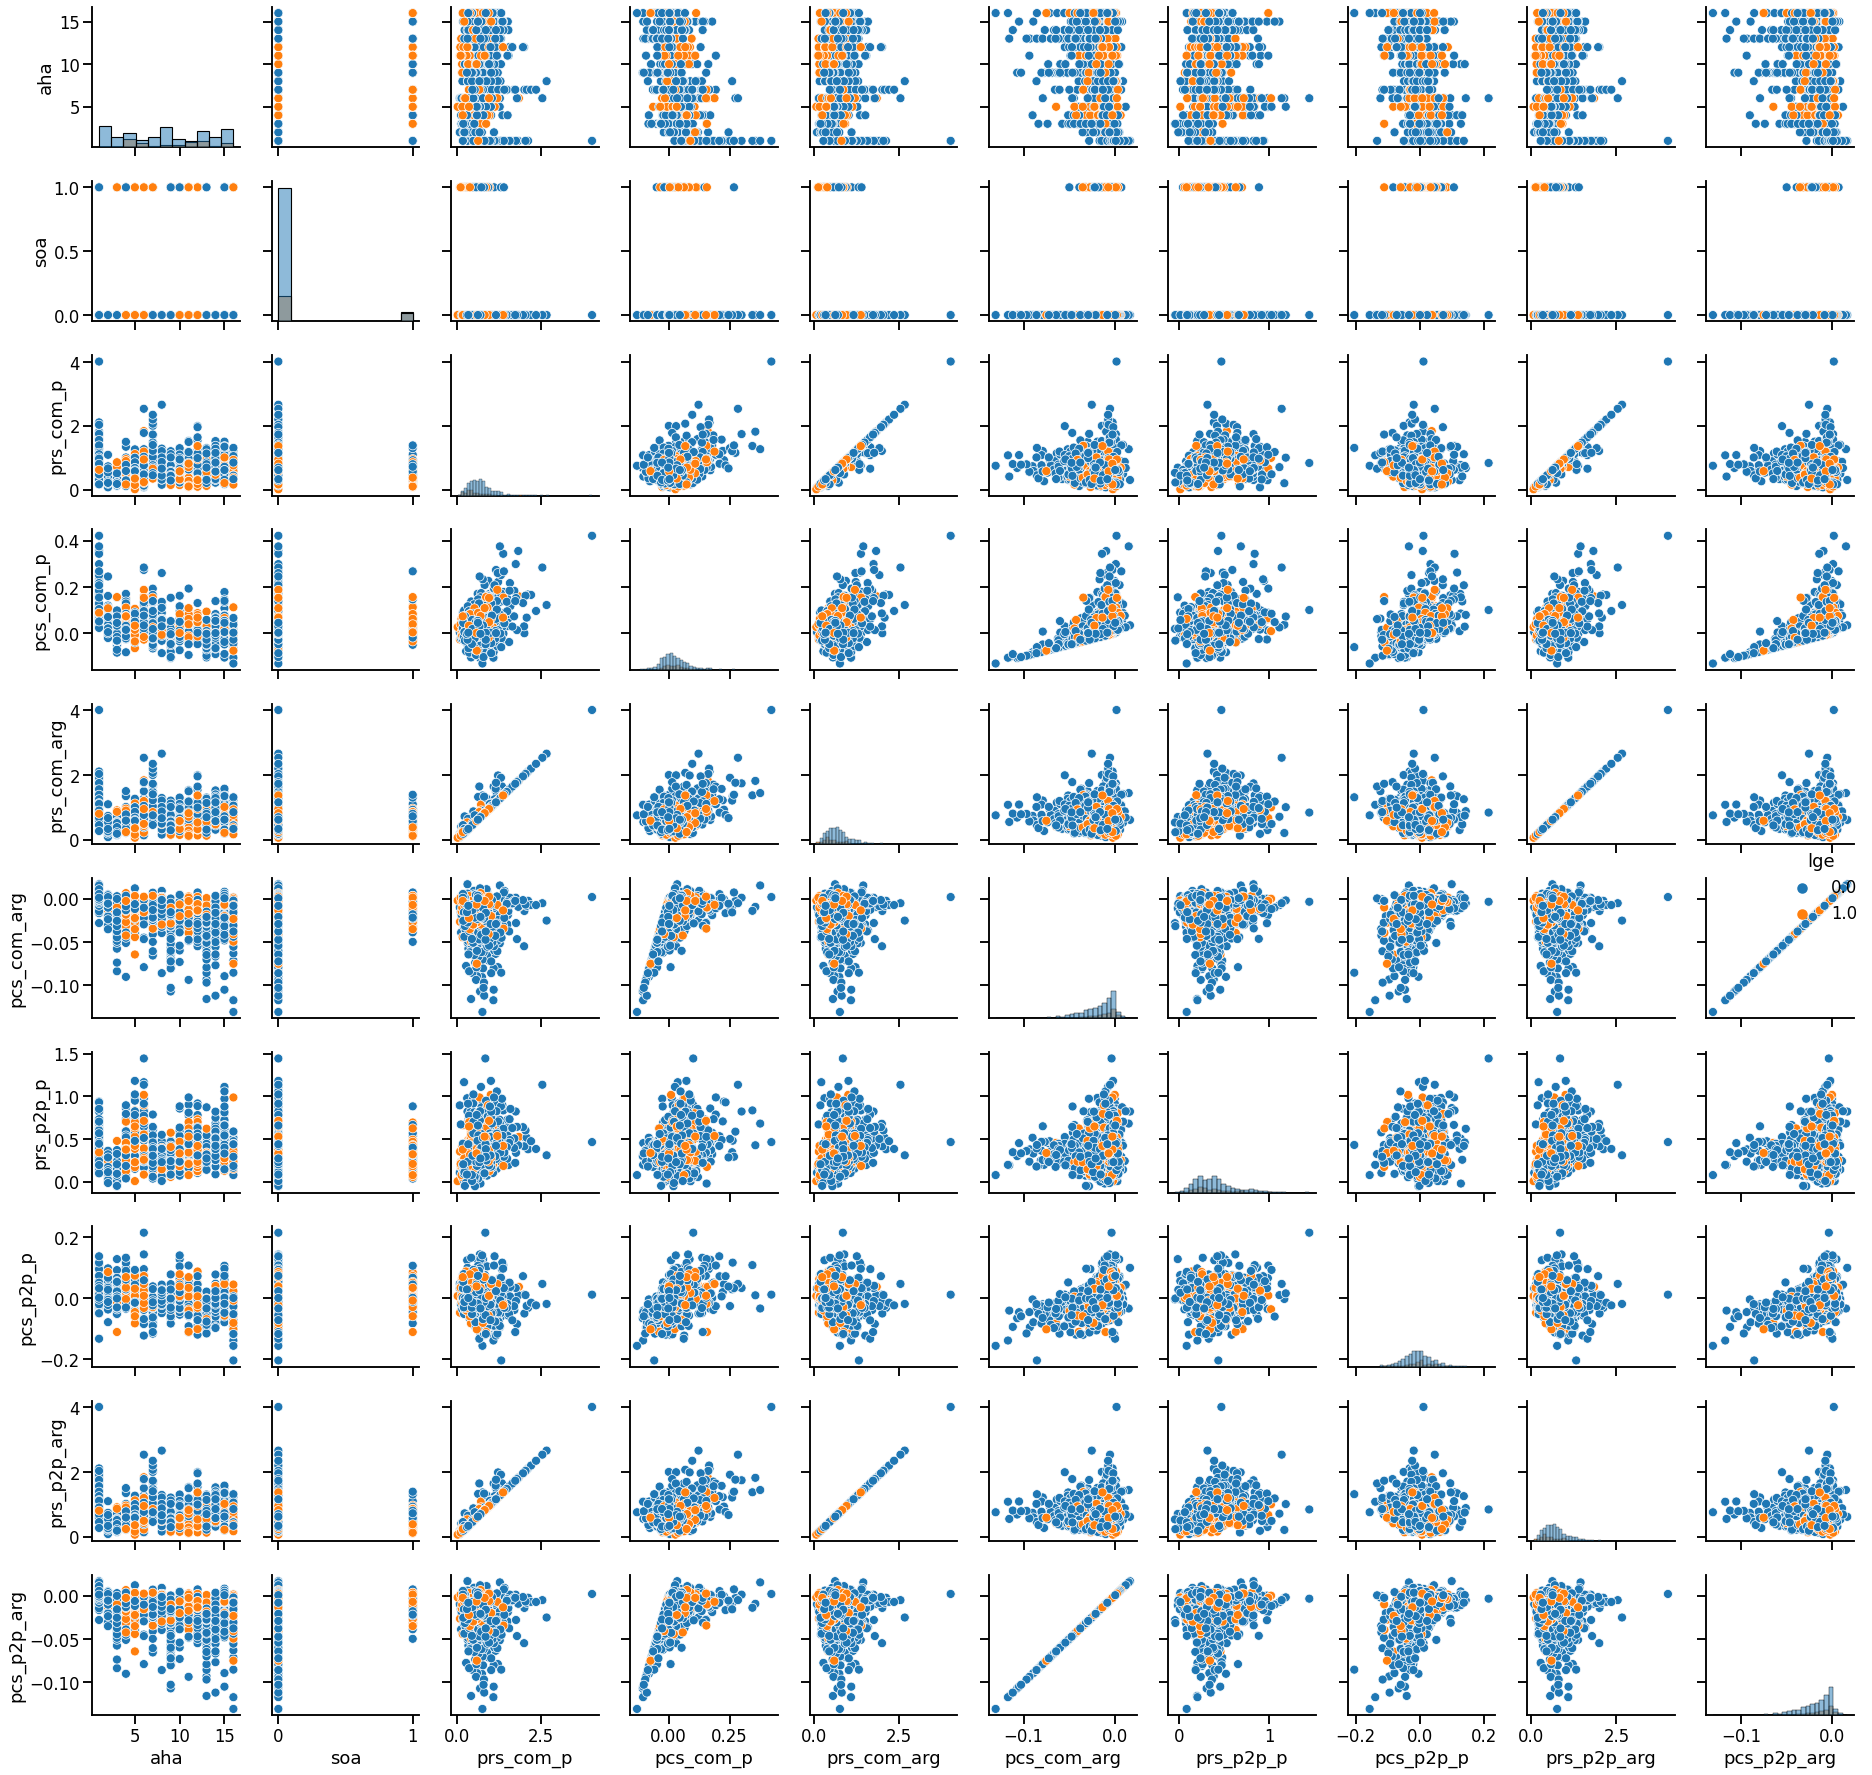

In [20]:
sb.set_context("talk")
g = sb.pairplot(data=df_peak,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

# Correlations comp strain values

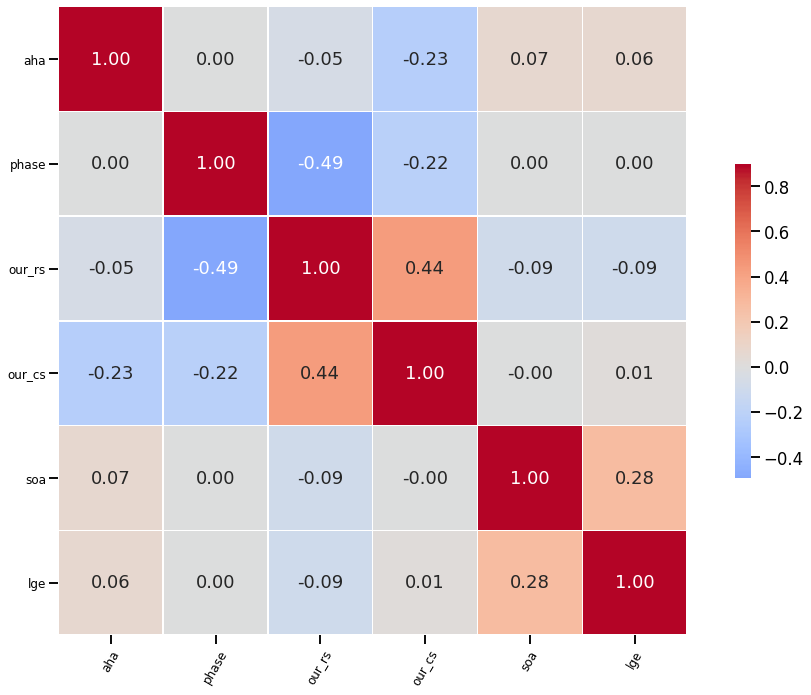

In [21]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_comp.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
#fig.savefig('strain_corr_cvi_vs_ours.png')

# Correlations p2p Strain

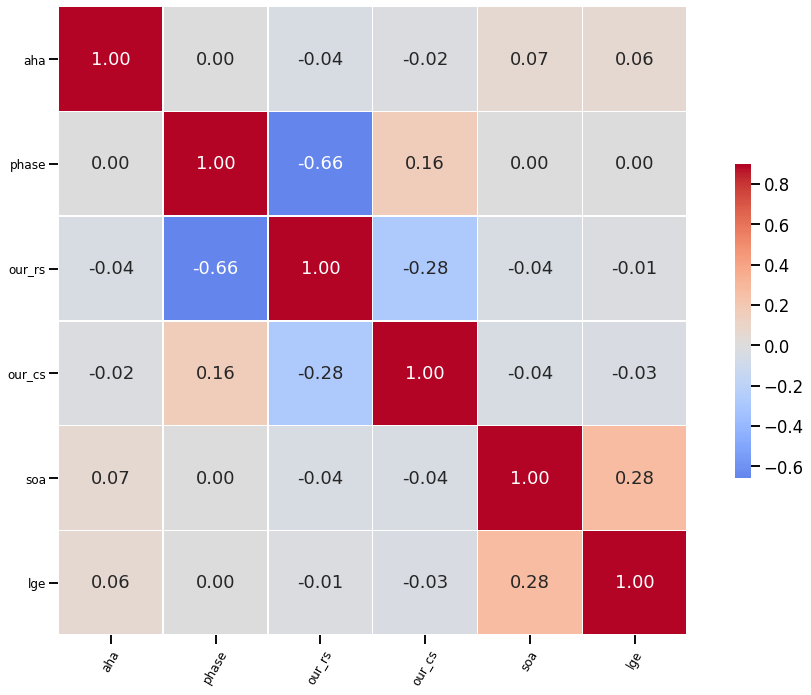

In [22]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_p2p.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()

# Correlations peak Strains

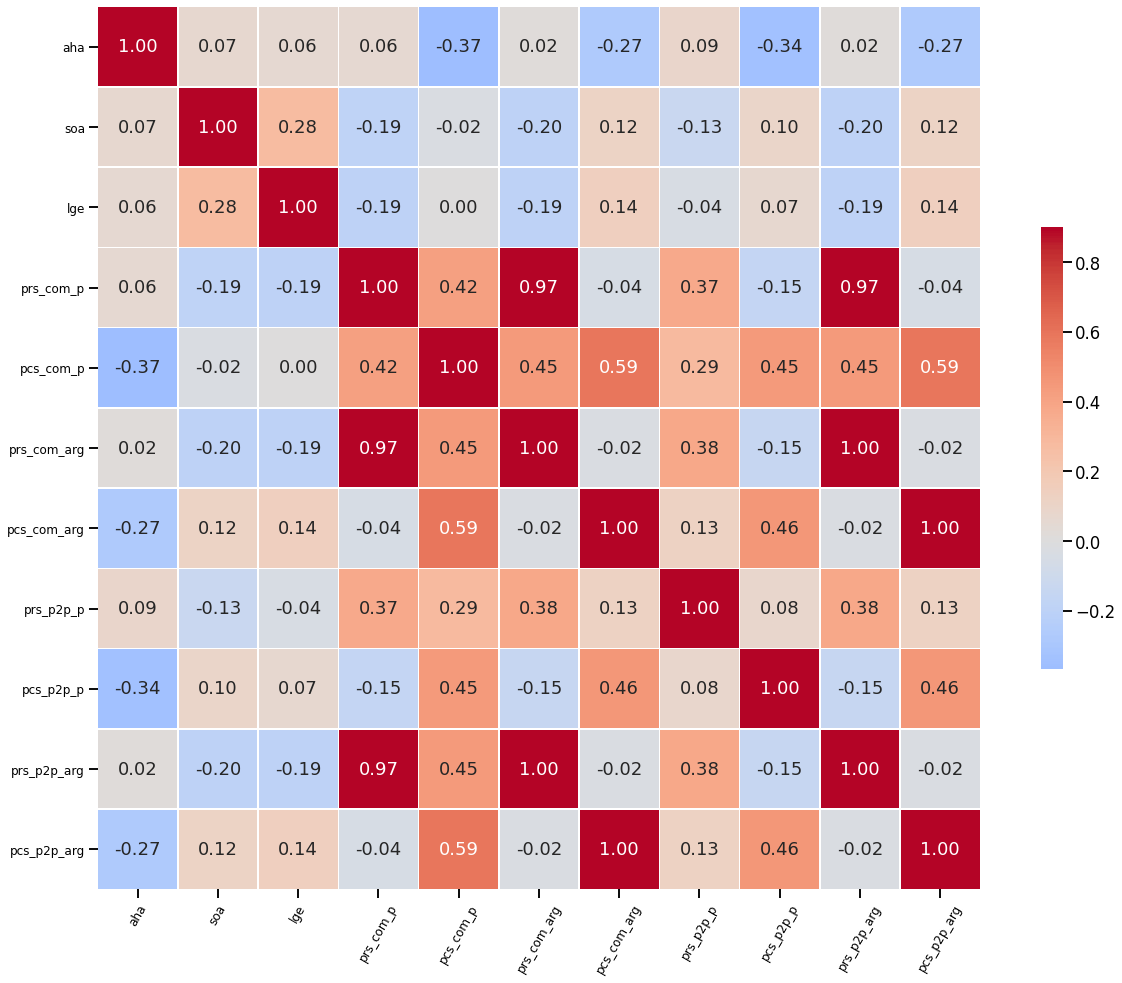

In [23]:
fig, ax = plt.subplots(figsize=(18,14)) 
corr = df_peak.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()

# Extract one feature Vector per Patient (56 patients times 16 segments times 5 phases times two feature (rs, cs))

- 32 LGE positive patients
- 24 LGE negative patients

# Strain per patient from composed df (56 x 16 x 5 x 2) --> 56, 160

(56, 80)
(56, 160)
(56, 80)
(56,)
********** Logistic Regression **********
[0.71428571 0.83333333 0.83333333 0.66666667 0.71428571]
Recall: 0.75 (+/- 0.07) [Logistic Regression]
Accuracy: 0.65 (+/- 0.15) [Logistic Regression]
********** Random Forest **********
[0.71428571 1.         0.66666667 0.33333333 0.85714286]
Recall: 0.71 (+/- 0.22) [Random Forest]
Accuracy: 0.54 (+/- 0.18) [Random Forest]
********** naive Bayes **********
[0.57142857 0.33333333 0.83333333 0.33333333 0.42857143]
Recall: 0.50 (+/- 0.19) [naive Bayes]
Accuracy: 0.50 (+/- 0.13) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 0.83333333 0.83333333 0.16666667 0.71428571]
Recall: 0.65 (+/- 0.25) [scaled DecissionTree]
Accuracy: 0.57 (+/- 0.22) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.16666667 0.66666667 0.33333333 0.42857143]
Recall: 0.43 (+/- 0.18) [KNN]
Accuracy: 0.37 (+/- 0.13) [KNN]
********** scaled SVC(poly) **********
[1.         1.         0.66666667 1.         1.  

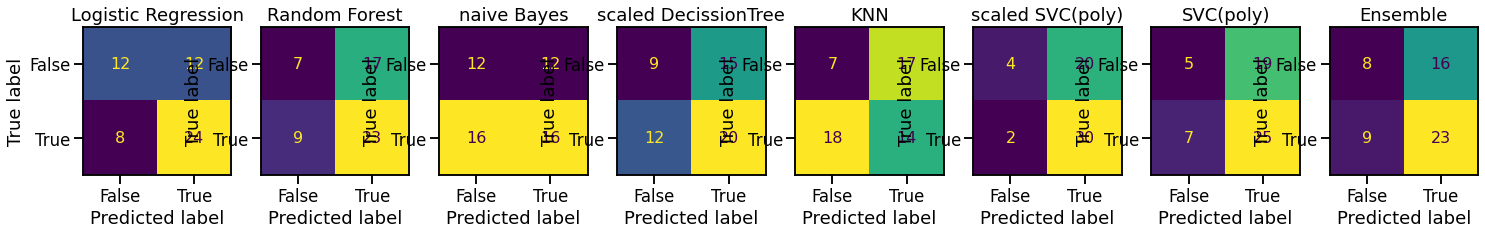

In [24]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate(x,y)

# Strain per patient from p2p df (56 x 16 x 5 x 2) --> 56, 160

(56, 80)
(56, 160)
(56, 80)
(56,)
********** Logistic Regression **********
[0.42857143 0.33333333 0.83333333 0.5        0.71428571]
Recall: 0.56 (+/- 0.18) [Logistic Regression]
Accuracy: 0.50 (+/- 0.13) [Logistic Regression]
********** Random Forest **********
[0.85714286 0.66666667 0.5        0.5        1.        ]
Recall: 0.70 (+/- 0.20) [Random Forest]
Accuracy: 0.59 (+/- 0.17) [Random Forest]
********** naive Bayes **********
[0.57142857 0.33333333 0.5        0.5        0.85714286]
Recall: 0.55 (+/- 0.17) [naive Bayes]
Accuracy: 0.57 (+/- 0.14) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.33333333 0.33333333 0.83333333 0.14285714]
Recall: 0.44 (+/- 0.24) [scaled DecissionTree]
Accuracy: 0.44 (+/- 0.22) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.33333333 0.33333333 0.83333333 0.57142857]
Recall: 0.53 (+/- 0.19) [KNN]
Accuracy: 0.54 (+/- 0.13) [KNN]
********** scaled SVC(poly) **********
[0.85714286 1.         0.5        1.         1.  

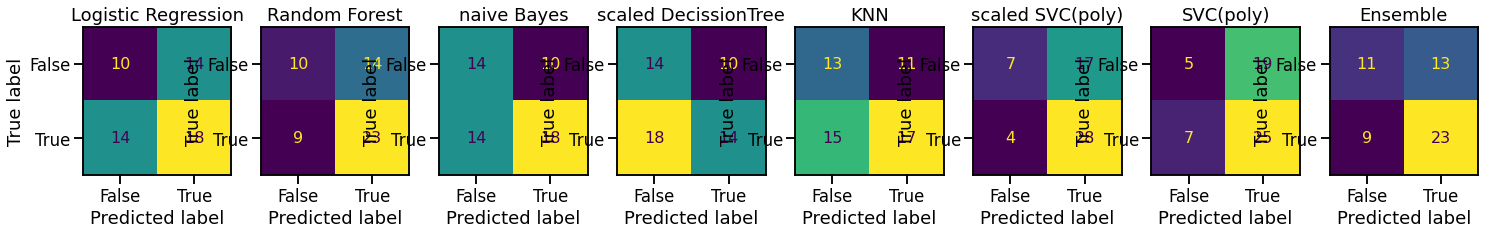

In [25]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_p2p.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_p2p.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate(x,y)

# Strain per patient from p2p & composed df (56 x 16 x 5 x 2 x 2) --> 56, 320

# Per patient with:

- p2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

- ed2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

--> 320 features per patient

(56, 80)
(56, 320)
(56, 80)
(56,)
********** Logistic Regression **********
[0.57142857 0.5        0.83333333 0.66666667 0.71428571]
Recall: 0.66 (+/- 0.12) [Logistic Regression]
Accuracy: 0.61 (+/- 0.05) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.83333333 0.66666667 0.5        0.85714286]
Recall: 0.69 (+/- 0.14) [Random Forest]
Accuracy: 0.54 (+/- 0.16) [Random Forest]
********** naive Bayes **********
[0.57142857 0.33333333 0.5        0.33333333 0.71428571]
Recall: 0.49 (+/- 0.15) [naive Bayes]
Accuracy: 0.54 (+/- 0.11) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.5        0.5        0.83333333 0.28571429]
Recall: 0.51 (+/- 0.18) [scaled DecissionTree]
Accuracy: 0.50 (+/- 0.13) [scaled DecissionTree]
********** KNN **********
[0.28571429 0.33333333 0.66666667 0.33333333 0.28571429]
Recall: 0.38 (+/- 0.14) [KNN]
Accuracy: 0.47 (+/- 0.09) [KNN]
********** scaled SVC(poly) **********
[1.         0.83333333 0.5        1.         1.  

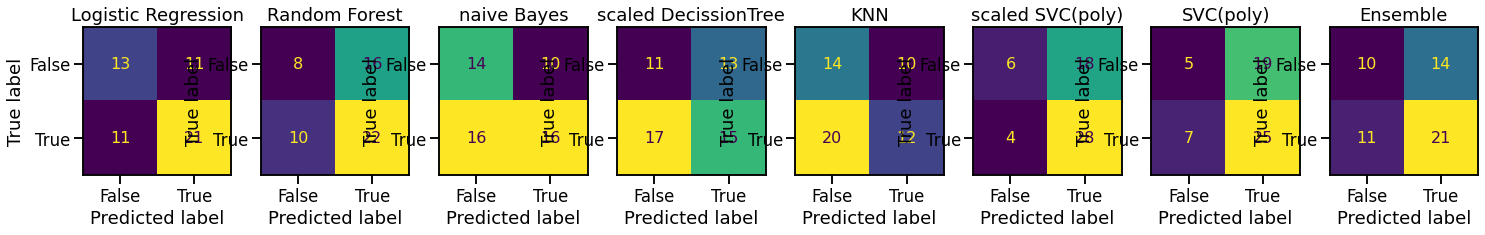

In [26]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc_p = np.stack(df_strain_p2p.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr_p = np.stack(df_strain_p2p.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr, xc_p, xr_p], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate(x,y)

# Peak Strain (Phase) per patient from composed df

(56, 16)
(56, 32)
(56, 16)
(56,)
********** Logistic Regression **********
[0.71428571 0.83333333 0.83333333 0.83333333 0.71428571]
Recall: 0.79 (+/- 0.06) [Logistic Regression]
Accuracy: 0.70 (+/- 0.12) [Logistic Regression]
********** Random Forest **********
[0.71428571 1.         0.83333333 0.83333333 0.71428571]
Recall: 0.82 (+/- 0.10) [Random Forest]
Accuracy: 0.70 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[0.71428571 1.         0.83333333 0.66666667 0.28571429]
Recall: 0.70 (+/- 0.24) [naive Bayes]
Accuracy: 0.63 (+/- 0.19) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.83333333 0.66666667 0.33333333 0.85714286]
Recall: 0.62 (+/- 0.21) [scaled DecissionTree]
Accuracy: 0.59 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.28571429 0.83333333 0.33333333 0.33333333 0.28571429]
Recall: 0.41 (+/- 0.21) [KNN]
Accuracy: 0.47 (+/- 0.16) [KNN]
********** scaled SVC(poly) **********
[0.71428571 1.         1.         1.         1.   

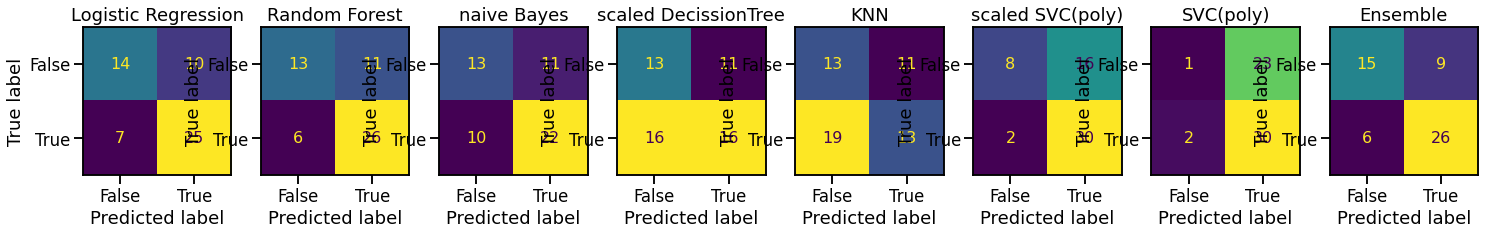

In [27]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate(x,y)

# Peak Strain (arg-min/max) per patient from composed df

(56, 16)
(56, 32)
(56, 16)
(56,)
********** Logistic Regression **********
[0.71428571 0.83333333 0.83333333 0.83333333 0.71428571]
Recall: 0.79 (+/- 0.06) [Logistic Regression]
Accuracy: 0.68 (+/- 0.12) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.83333333 0.83333333 0.5        0.71428571]
Recall: 0.72 (+/- 0.12) [Random Forest]
Accuracy: 0.66 (+/- 0.15) [Random Forest]
********** naive Bayes **********
[0.71428571 1.         0.5        0.66666667 0.57142857]
Recall: 0.69 (+/- 0.17) [naive Bayes]
Accuracy: 0.65 (+/- 0.12) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.16666667 0.5        0.16666667 0.85714286]
Recall: 0.42 (+/- 0.26) [scaled DecissionTree]
Accuracy: 0.45 (+/- 0.17) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.66666667 0.5        0.         0.42857143]
Recall: 0.40 (+/- 0.22) [KNN]
Accuracy: 0.47 (+/- 0.14) [KNN]
********** scaled SVC(poly) **********
[0.71428571 1.         1.         1.         0.857

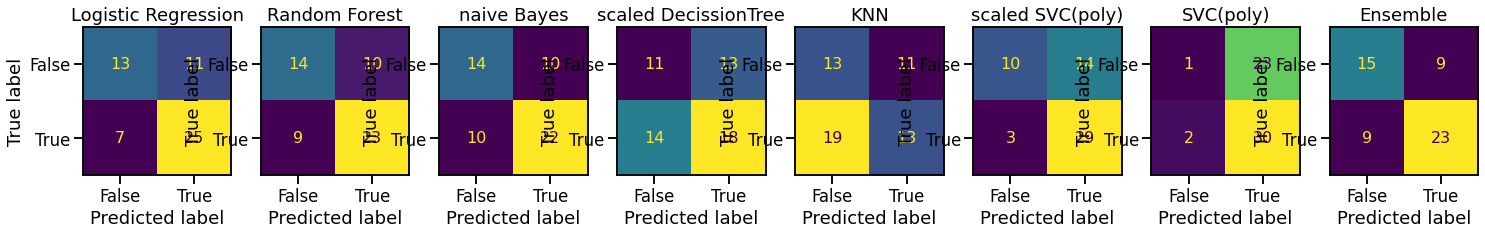

In [28]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate(x,y)

# Peak Strain (Phase) per patient from p2p df

(56, 16)
(56, 32)
(56, 16)
(56,)
********** Logistic Regression **********
[0.42857143 0.33333333 0.83333333 0.66666667 0.71428571]
Recall: 0.60 (+/- 0.19) [Logistic Regression]
Accuracy: 0.61 (+/- 0.07) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.33333333 0.83333333 0.5        1.        ]
Recall: 0.65 (+/- 0.24) [Random Forest]
Accuracy: 0.54 (+/- 0.21) [Random Forest]
********** naive Bayes **********
[0.71428571 0.         0.83333333 0.5        0.71428571]
Recall: 0.55 (+/- 0.30) [naive Bayes]
Accuracy: 0.61 (+/- 0.17) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 0.         0.66666667 0.66666667 0.85714286]
Recall: 0.58 (+/- 0.30) [scaled DecissionTree]
Accuracy: 0.48 (+/- 0.22) [scaled DecissionTree]
********** KNN **********
[0.71428571 0.16666667 0.5        0.66666667 0.71428571]
Recall: 0.55 (+/- 0.21) [KNN]
Accuracy: 0.61 (+/- 0.17) [KNN]
********** scaled SVC(poly) **********
[0.85714286 0.83333333 1.         1.         1.   

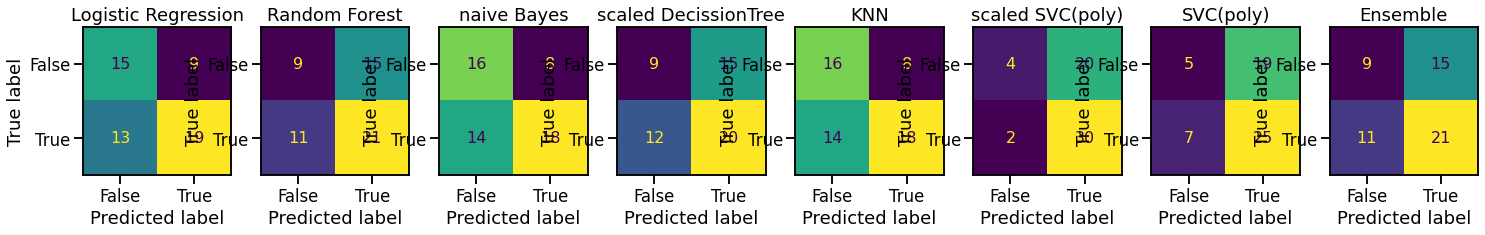

In [29]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate(x,y)

# Peak Strain (arg-min/max) per patient from p2p df

(56, 16)
(56, 32)
(56, 16)
(56,)
********** Logistic Regression **********
[0.71428571 0.83333333 0.83333333 0.83333333 0.71428571]
Recall: 0.79 (+/- 0.06) [Logistic Regression]
Accuracy: 0.68 (+/- 0.12) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.83333333 0.83333333 0.5        0.71428571]
Recall: 0.72 (+/- 0.12) [Random Forest]
Accuracy: 0.66 (+/- 0.15) [Random Forest]
********** naive Bayes **********
[0.71428571 1.         0.5        0.66666667 0.57142857]
Recall: 0.69 (+/- 0.17) [naive Bayes]
Accuracy: 0.65 (+/- 0.12) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 0.16666667 0.5        0.16666667 0.85714286]
Recall: 0.48 (+/- 0.28) [scaled DecissionTree]
Accuracy: 0.48 (+/- 0.18) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.66666667 0.5        0.         0.42857143]
Recall: 0.40 (+/- 0.22) [KNN]
Accuracy: 0.47 (+/- 0.14) [KNN]
********** scaled SVC(poly) **********
[0.71428571 1.         1.         1.         0.857

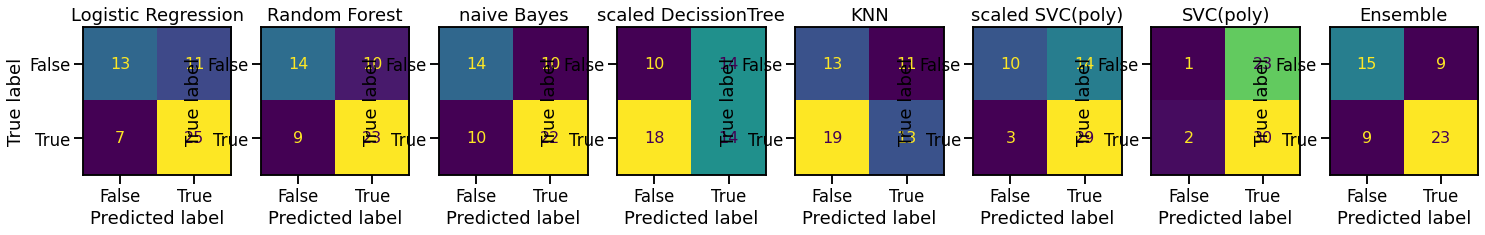

In [30]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate(x,y)

# Peak Strains concatenatet per patient

(56, 16)
(56, 128)
(56, 16)
(56,)
********** Logistic Regression **********
[0.71428571 0.5        0.83333333 0.83333333 0.71428571]
Recall: 0.72 (+/- 0.12) [Logistic Regression]
Accuracy: 0.70 (+/- 0.08) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.66666667 0.66666667 0.66666667 0.71428571]
Recall: 0.66 (+/- 0.05) [Random Forest]
Accuracy: 0.59 (+/- 0.08) [Random Forest]
********** naive Bayes **********
[0.71428571 0.5        0.66666667 0.66666667 0.57142857]
Recall: 0.62 (+/- 0.08) [naive Bayes]
Accuracy: 0.63 (+/- 0.10) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.5        0.5        0.33333333 0.85714286]
Recall: 0.52 (+/- 0.18) [scaled DecissionTree]
Accuracy: 0.47 (+/- 0.16) [scaled DecissionTree]
********** KNN **********
[0.71428571 0.5        0.5        0.33333333 0.57142857]
Recall: 0.52 (+/- 0.12) [KNN]
Accuracy: 0.52 (+/- 0.10) [KNN]
********** scaled SVC(poly) **********
[0.71428571 0.83333333 1.         1.         1.  

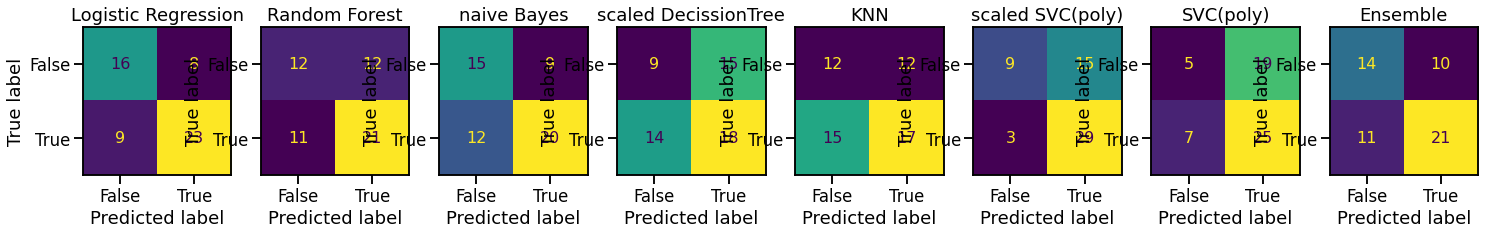

In [31]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc2 = np.stack(df_peak.groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr2 = np.stack(df_peak.groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc3 = np.stack(df_peak.groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr3 = np.stack(df_peak.groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc4 = np.stack(df_peak.groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr4 = np.stack(df_peak.groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr,xc2,xr2,xc3,xr3,xc4,xr4], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate(x,y)

In [24]:
# check for nan and infinit values
x[~np.isfinite(x)]

array([], dtype=float32)

In [61]:
df_strain_t.head()

,pat,aha,phase,our_rs,our_cs,soa,lge
0,aa_20180710,1,0,1.786674,0.021748,0,0
1,aa_20180710,1,1,1.149996,0.000487,0,0
2,aa_20180710,1,2,1.066246,0.286125,0,0
3,aa_20180710,1,3,0.157604,0.198737,0,0
4,aa_20180710,1,4,0.392708,0.091887,0,0


In [92]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

temp_2d = TSNE(n_components=2, perplexity=4, learning_rate=50).fit_transform(x)
#temp_2d = PCA(n_components=2).fit_transform(x)
temp_2d = nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
).fit_transform(x,y)

/home/minority/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


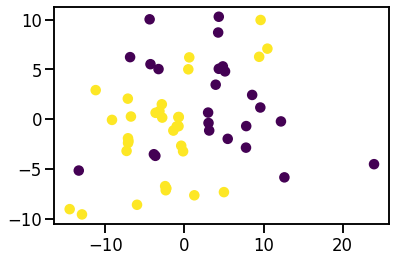

In [93]:
plt.scatter(temp_2d[:,0], temp_2d[:,1], c=y)

********** Logistic Regression **********
[0.71428571 1.         0.66666667 0.83333333 0.85714286]
Recall: 0.81 (+/- 0.12) [Logistic Regression]
Accuracy: 0.81 (+/- 0.08) [Logistic Regression]
********** Random Forest **********
[0.71428571 1.         1.         0.83333333 0.85714286]
Recall: 0.88 (+/- 0.11) [Random Forest]
Accuracy: 0.86 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[0.71428571 1.         0.66666667 0.83333333 1.        ]
Recall: 0.84 (+/- 0.14) [naive Bayes]
Accuracy: 0.77 (+/- 0.15) [naive Bayes]
********** scaled DecissionTree **********
[1.         1.         0.83333333 0.83333333 0.85714286]
Recall: 0.90 (+/- 0.08) [scaled DecissionTree]
Accuracy: 0.93 (+/- 0.04) [scaled DecissionTree]
********** DecissionTree **********
[1.         1.         0.83333333 0.83333333 0.85714286]
Recall: 0.90 (+/- 0.08) [DecissionTree]
Accuracy: 0.91 (+/- 0.06) [DecissionTree]
********** scaled SVC(poly) **********
[0.85714286 0.66666667 0.66666667 0.83333333 1.      

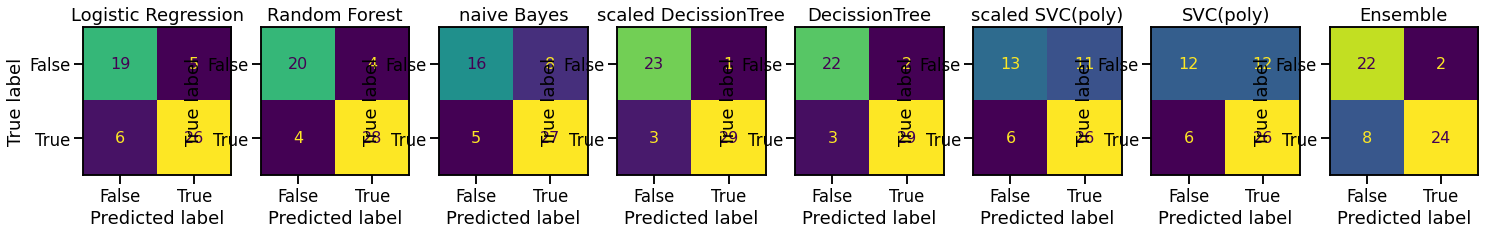

In [94]:
cross_validate(temp_2d,y)

# Read Peak Strain values

In [245]:
df_strain = pd.read_csv('df_DMD_peaks.csv')
df_strain

,pat,aha,cvi_prs,cvi_pcs,our_prs,our_pcs,soa,lge
0,aa_20180710,1,16.96,-12.07,203.658519,1.772480,0,0
1,aa_20180710,2,30.72,-18.35,123.428568,-6.393648,0,0
2,aa_20180710,3,23.04,-14.84,70.041829,-9.489236,0,0
3,aa_20180710,4,30.35,-18.39,117.359146,4.865555,0,0
4,aa_20180710,5,43.19,-21.56,87.832511,-8.130475,0,0
...,...,...,...,...,...,...,...,...
907,wr_20170905,12,37.09,-20.37,71.756630,-5.373871,0,1
908,wr_20170905,13,70.69,-28.02,40.757867,-9.318804,0,0
909,wr_20170905,14,73.72,-28.50,110.297893,-1.468794,0,0
910,wr_20170905,15,46.32,-21.34,67.661423,0.236923,0,0


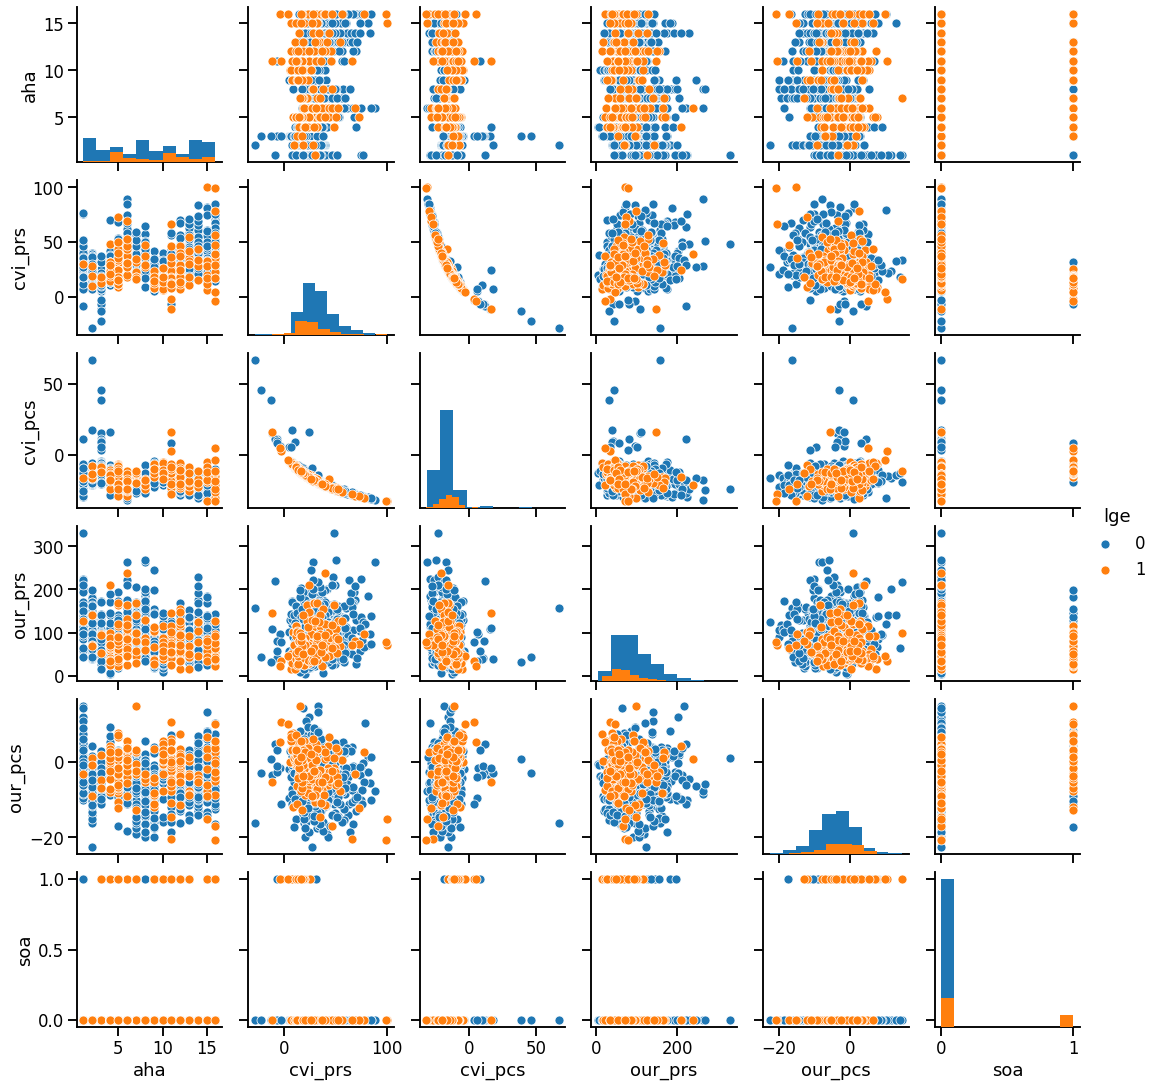

In [223]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain,diag_kind="hist", hue='lge')
#g.fig.set_size_inches(14,10)
#g.savefig('strains_pairplot_by_normal.png')

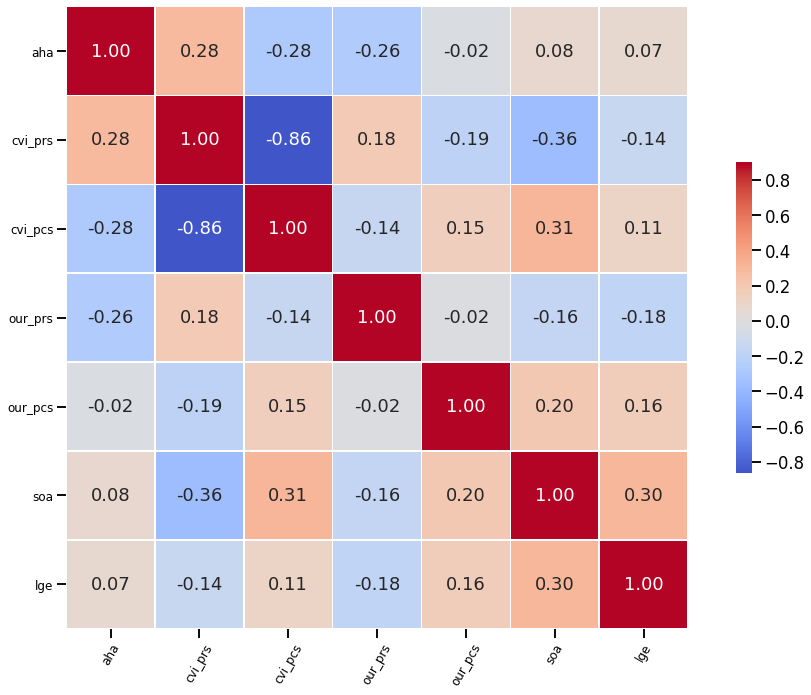

In [267]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
fig.savefig('strain_corr_cvi_vs_ours.png')

In [184]:
df_strain.head()

,pat,aha,cvi_prs,cvi_pcs,our_prs,our_pcs,soa,lge
0,aa_20180710,1,16.96,-12.07,130.806351,-8.810040,0,0
1,aa_20180710,2,30.72,-18.35,223.150068,-1.038311,0,0
2,aa_20180710,3,23.04,-14.84,65.394576,-13.673295,0,0
3,aa_20180710,4,30.35,-18.39,131.154533,-1.147776,0,0
4,aa_20180710,5,43.19,-21.56,186.809730,-9.253495,0,0


In [277]:
import glob
files = sorted(glob.glob('*'))
files

['2021_09_v1_strains',
 'AHA_segments.ipynb',
 'Arxiv_crawler.ipynb',
 'DMDTarique_1.9.xlsx',
 'DMD_PCS.txt',
 'DMD_PRS.txt',
 'angle_calculation.ipynb',
 'centers.nii',
 'centers.nrrd',
 'comp.tfm',
 'df_DMD.csv',
 'df_DMD_peaks.csv',
 'df_DMD_time.csv',
 'df_DMD_val.csv',
 'df_kfold.csv',
 'rotate_inplane.ipynb',
 'snipet.py',
 'strain_corr_cvi_vs_ours.png',
 'strains_pairplot_by_normal.png',
 'strains_pairplot_by_segment.png',
 'tmp',
 'tmp_paper']

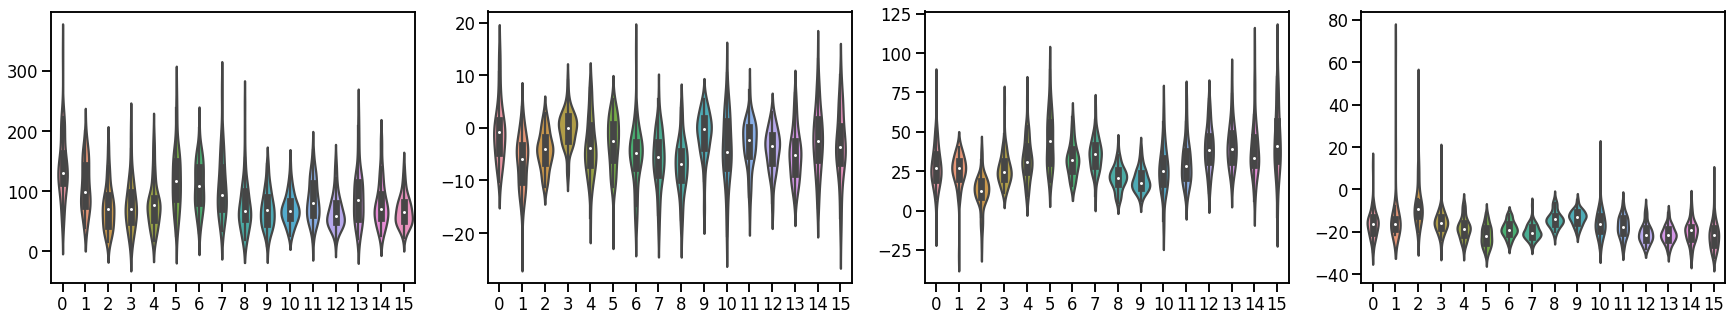

In [268]:
prs = np.stack(df_strain.groupby(['pat'])['our_prs'].apply(list).values).astype(np.float32)
pcs = np.stack(df_strain.groupby(['pat'])['our_pcs'].apply(list).values).astype(np.float32)
prs_cvi = np.stack(df_strain.groupby(['pat'])['cvi_prs'].apply(list).values).astype(np.float32)
pcs_cvi = np.stack(df_strain.groupby(['pat'])['cvi_pcs'].apply(list).values).astype(np.float32)
soa = np.stack(df_strain.groupby(['pat'])['soa'].apply(list).values).astype(np.float32)
gt = np.stack(df_strain.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
fix, axes = plt.subplots(1,4, figsize=(30,5))
for ax, f in zip(axes, [prs, pcs, prs_cvi, pcs_cvi]):
    sb.violinplot(data=pd.DataFrame(f, columns=list(range(f.shape[1]))), ax=ax)
plt.show()

In [18]:
@interact_manual
def evaluate(pred_data=['cvi', 'our', 'soa'], rs_smaller_than='', cs_bigger_than=''):
    global gt
    gt = gt

    pred = soa
    if pred_data in ['cvi', 'our']: # we need to threshold
        if pred_data =='cvi':rs, cs = prs_cvi, pcs_cvi
        if pred_data =='our':rs, cs = prs, pcs
        if len(rs_smaller_than)>0: rs = rs<float(rs_smaller_than)
        if len(cs_bigger_than)>0: cs = cs>float(cs_bigger_than)
        rs, cs = rs>0, cs>0
        pred = np.logical_and(rs, cs)
        
    evaluate_segments(pred,gt)

interactive(children=(Dropdown(description='pred_data', options=('cvi', 'our', 'soa'), value='cvi'), Text(valu…

gt: (54, 16)
pred: (54, 16)
TP: 0, FP: 0, TN: 0, FN: 0
LGE abnormal segments: 0
Mean LGE segments per patient: 3.1481+/-3.6076
Pred abnormal segments: 0
Mean pred segments per patient: 1892.9905+/-447.9567
Identified abnormal patients: 54. Correct (at least one correct segment) identified: 0
acc: nan, prec: nan, sensitivity: nan


/home/minority/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars
/home/minority/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars
/home/minority/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


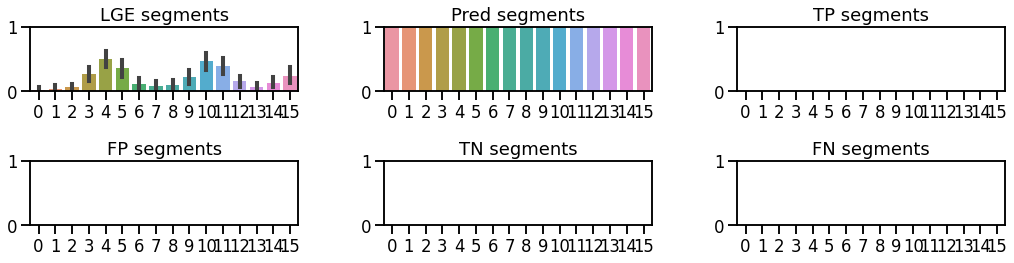

In [162]:
evaluate_segments(prs,gt)

In [146]:
df =pd.read_excel('DMDTarique_1.9.xlsx', sheet_name='clean DMD', engine='openpyxl')

In [221]:
y_len = 16
# ED, MS, ES, PF, MD
idx_phase = np.array([16,4,8,10,14])
print(idx_phase)
shift_to_left = np.roll(idx_phase, -1)
print(shift_to_left)
print('divide by 2 and than mod by length')
print(np.mod((idx_phase + shift_to_left)//2,y_len))
print('mod by length and than divide by 2')
print(np.mod((idx_phase + shift_to_left),y_len)//2)
print('we need a different operation for the cycle case:')
np.where(shift_to_left>idx_phase,np.mod((idx_phase + shift_to_left)//2,y_len),np.mod((idx_phase + shift_to_left),y_len)//2 )

[16  4  8 10 14]
[ 4  8 10 14 16]
divide by 2 and than mod by length
[10  6  9 12 15]
mod by length and than divide by 2
[2 6 1 4 7]
we need a different operation for the cycle case:


array([ 2,  6,  9, 12, 15])

In [147]:
df['lgepos']

0                                             NaN
1                                             NaN
2                                             NaN
3                       4, 5, 6, 7, 9, 10, 11, 12
4                                            4, 5
5                                    4, 5, 10, 11
6                     4, 5, 6, 10, 11, 12, 13, 16
7                                             NaN
8                                5, 6, 11, 12, 16
9                                             NaN
10                                   5, 6, 11, 12
11                                            NaN
12                                            NaN
13                                            NaN
14                                            NaN
15                                            NaN
16                                        3, 5, 6
17                                            NaN
18                                   5, 6, 11, 12
19                                   5, 7, 11, 12


In [148]:
df.columns

Index(['pat', 'tar visual', 'tar strain', 'Age', 'Gender', 'Weight', 'Height',
       'BSA', 'HR', 'Systolic BP', 'Diastolic BP', 'LVEF', 'LVEDV', 'LVESV',
       'LV mass', 'RVEF', 'RVEDV', 'RVESV', 'LGE present',
       'Nocturnal BiPAP Use', 'Resp support required', 'Wheelchair',
       'Ambulatory', 'Steroid Use', 'Any Med Use', 'ACE-I', 'ARB', 'MRA', 'BB',
       'mid-cavity peak radial strain',
       'mid-cavity peak circumferential strain', 'soa', 'lgepos'],
      dtype='object')

# Describe the distribution of numeric values

In [149]:
import ipywidgets
from ipywidgets import interact
@interact
def plot_columns(cols=df.columns):
    try:
        sb.violinplot(data=df[cols], sharey=False)
    except Exception as e:
        print(e)
        return df[cols].head()

interactive(children=(Dropdown(description='cols', options=('pat', 'tar visual', 'tar strain', 'Age', 'Gender'…

# Read our predicted abnormal segments - old format and files

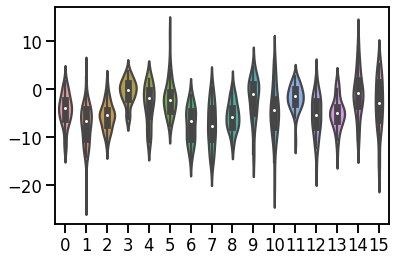

In [59]:
# read our strain values
strains_path = 'DMD_PCS.txt'

strains = []
patient = 0
temp = ''
app = True
with open(strains_path) as strain_file:
    for l in strain_file:
        temp = temp + l
        if ']' in l:
            #print('{}: {}'.format(patient, temp))
            strains.append(temp)
            temp = ''
            patient = patient +1
re_split_lambda = lambda x : np.array(x.replace('[','').replace(']','').split(), dtype=np.float32)
strains_split = np.stack(list(map(re_split_lambda,strains)))
sb.violinplot(data=pd.DataFrame(strains_split, columns=list(range(strains_split.shape[1]))))

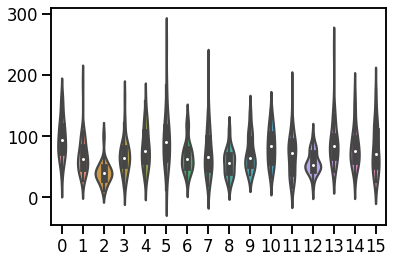

In [60]:
# read our strain values
rstrains_path = 'DMD_PRS.txt'

rstrains = []
patient = 0
temp = ''
app = True
with open(rstrains_path) as strain_file:
    for l in strain_file:
        temp = temp + l
        if ']' in l:
            #print('{}: {}'.format(patient, temp))
            rstrains.append(temp)
            temp = ''
            patient = patient +1
re_split_lambda = lambda x : np.array(x.replace('[','').replace(']','').split(), dtype=np.float32)
rstrains_split = np.stack(list(map(re_split_lambda,rstrains)))
sb.violinplot(data=pd.DataFrame(rstrains_split, columns=list(range(rstrains_split.shape[1]))))

# Read the patient based CV splits - no longer neccessary, as we now have files for all splits

In [62]:
# make sure to read the dataset specific split file
df_split = pd.read_csv('df_kfold.csv')

# filter the metadata dataframe by fold n patients - later use all!!!
print('All folds, train&val: {}'.format(df_split.shape))
df_split = df_split[df_split['fold']==0]
print('fold 0 - train & val: {}'.format(df_split.shape))
df_split = df_split[df_split['modality']=='train']
df_fold0 = df[df['pat'].isin(df_split['patient'])]
print('fold 0 - train: {}'.format(df_fold0.shape))

df_strain_fold0 = df_strain[df_strain['patient id'].isin(df_split['patient'])]
print('strain fold 0 with 16 segments: {}'.format(df_strain_fold0.shape))

All folds, train&val: (228, 5)
fold 0 - train & val: (57, 5)
fold 0 - train: (42, 33)
strain fold 0 with 16 segments: (3360, 6)


# Calculate the Binary hit or miss ratios
Between LGE Segments and Segments defined by Circle or Tarique

## Hints to both columns

### Column: 'Tarique abnormal'

bullsplot used here
tarique, bullsplot, motion curves
11 - mid inferolateral 

first: quality check: single segments only is very rare, two segments are better/more often that means more plausible. Not just the septum is affected. If all segments are affected, tracking may be wrong. 
second: based on experience, 11 and 12 AHA are mostly affected. Check also on circumferential and radial strain values, are they low? Bullseye plot is used for help.

### Column: 'Strain diff' 

Bezieht sich auf die orginal column: 'Segment from strain if different'

- tarique says this is difference between D and F
- tarique says this column is not helpful
- tarique says this columns relates to if different from LGE

He also said that this column shows the additional segments when he applies the Strain thresholding



In [154]:
gt_label = 'lge'
pred_label = 'soa' # 'Strain diff'
#pred_label = 'Strain diff'

@interact_manual
def calc_metrics_for_sub_df(col=df.columns, whitelist_by='', greater_as='', smaller_than=''):
    global lge_segments, mot_segments
    #print(col)
    temp = df_strain
    print('LGE positive patientes (abnormal motion in at least one segment) : {}'.format(sum(temp['lge']==1)))
    print('LGE negative patients (no motion abnormality) : {}'.format(sum(temp['lge']==0)))
    #temp = temp[msk]
    if len(whitelist_by)>=1:
        print('filter by: {}'.format(whitelist_by))
        temp = temp[temp[col].str.lower()==whitelist_by.lower()]
    if len(greater_as)>=1:
        print('greater as: {}'.format(greater_as))
        temp = temp[temp[col]>float(greater_as)]
    if len(smaller_than)>=1:
        print('smaller than: {}'.format(smaller_than))
        temp = temp[temp[col]<float(smaller_than)]
    print(temp.shape)
    
    # Extract binary array from segments for all patients
    lge_segments = np.stack(temp[gt_label].fillna(0).apply(extract_segments))
    # Extract binary array from segments for all patients
    mot_segments = np.stack(temp[pred_label].fillna(0).apply(extract_segments))
    evaluate_segments(mot_segments, lge_segments)
    

interactive(children=(Dropdown(description='col', options=('pat', 'tar visual', 'tar strain', 'Age', 'Gender',…

In [42]:
# Circumferential Strain
# we have only strain values of 42 patients, here we compare only these 42 patients!!!

@interact_manual
def calc_metrics_for_sub_df(greater_as='0', smaller_than=''):
    global lge_segments, mot_segments
    temp = df_fold0 # filter fold0 train split
    print('LGE positive patientes (abnormal motion in at least one segment) : {}'.format(sum(temp['LGE present'].str.lower()=='y')))
    print('LGE negative patients (no motion abnormality) : {}'.format(sum(temp['LGE present'].str.lower()=='n')))
    #msk = temp['LGE present'].str.lower()=='y' # only patients where we have an LGE
    #temp = temp[msk] # filter our predictions the same way
    if len(greater_as)>=1:
        print('greater as: {}'.format(greater_as))
        mot_segments = strains_split>float(greater_as)
    if len(smaller_than)>=1:
        print('smaller than: {}'.format(smaller_than))
        mot_segments = strains_split<float(smaller_than)
    #mot_segments = mot_segments[msk]
    
    # Extract binary array from segments for all patients
    lge_segments = np.stack(temp[gt_label].fillna(0).apply(extract_segments))
    evaluate_segments(mot_segments, lge_segments)
    

interactive(children=(Text(value='0', description='greater_as'), Text(value='', description='smaller_than'), B…

In [44]:
# Radial Strain
@interact_manual
def calc_metrics_for_sub_df(greater_as='', smaller_than='20'):
    global lge_segments, mot_segments
    temp = df_fold0 # filter fold0 train split
    print('LGE positive patientes (abnormal motion in at least one segment) : {}'.format(sum(temp['LGE present'].str.lower()=='y')))
    print('LGE negative patients (no motion abnormality) : {}'.format(sum(temp['LGE present'].str.lower()=='n')))
    if len(greater_as)>=1:
        print('greater as: {}'.format(greater_as))
        mot_segments = rstrains_split>float(greater_as)
    if len(smaller_than)>=1:
        print('smaller than: {}'.format(smaller_than))
        mot_segments = rstrains_split<float(smaller_than)
    
    # Extract binary array from segments for all patients
    lge_segments = np.stack(temp[gt_label].fillna(0).apply(extract_segments))
    evaluate_segments(mot_segments, lge_segments)
    

interactive(children=(Text(value='', description='greater_as'), Text(value='20', description='smaller_than'), …

In [64]:
# Circ & Radial Strain
@interact_manual
def calc_metrics_for_sub_df(pcs_greater_as='-2', prs_smaller_than='50'):
    global lge_segments, mot_segments,r_segments, c_segments
    temp = df_fold0 # filter fold0 train split
    print('LGE positive patientes (abnormal motion in at least one segment) : {}'.format(sum(temp['LGE present'].str.lower()=='y')))
    print('LGE negative patients (no motion abnormality) : {}'.format(sum(temp['LGE present'].str.lower()=='n')))
    if len(pcs_greater_as)>=1:
        print('greater as: {}'.format(pcs_greater_as))
        c_segments = strains_split>float(pcs_greater_as)
    if len(prs_smaller_than)>=1:
        print('smaller than: {}'.format(prs_smaller_than))
        r_segments = rstrains_split<float(prs_smaller_than)

    mot_segments = np.logical_xor(r_segments,c_segments)
    
    # Extract binary array from segments for all patients
    lge_segments = np.stack(temp[gt_label].fillna(0).apply(extract_segments))
    evaluate_segments(mot_segments, lge_segments)
    

interactive(children=(Text(value='-2', description='pcs_greater_as'), Text(value='50', description='prs_smalle…

In [ ]:
# from dataframe
np.stack(df_strain.groupby('patient id')['cvi_prs'].apply(list).values)

# Calculate some metrics step by step

In [26]:
(mot_segments.sum(axis=1)>0).sum()

11

In [54]:
# LGE and Circle predictions of abnormal and normal segments per patient
lge_seg_per_patient = lge_segments.sum(axis=1)
lge_normal_seg_per_patient = (lge_segments==0).sum(axis=1)
print('LGE ABnormal per patient: {}+/-{}'.format(lge_seg_per_patient.mean(), lge_seg_per_patient.std()))
print('LGE normal per patient: {}+/-{}'.format(lge_normal_seg_per_patient.mean(), lge_normal_seg_per_patient.std()))

mot_seg_per_patient = mot_segments.sum(axis=1)
mot_normal_seg_per_patient = (mot_segments==0).sum(axis=1)
print('Circle Strain ABnormal per patient: {}+/-{}'.format(mot_seg_per_patient.mean(), mot_seg_per_patient.std()))
print('Circle Strain normal per patient: {}+/-{}'.format(mot_normal_seg_per_patient.mean(), mot_normal_seg_per_patient.std()))

LGE ABnormal per patient: 5.666666666666667+/-3.130172486937389
LGE normal per patient: 10.333333333333334+/-3.130172486937389
Circle Strain ABnormal per patient: 1.0+/-1.4770978917519928
Circle Strain normal per patient: 15.0+/-1.4770978917519928


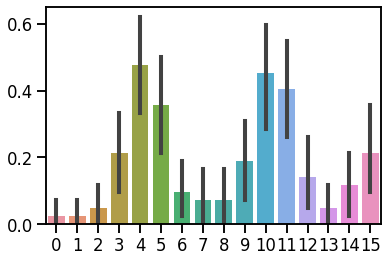

In [46]:
# how often does each segment occure as abnormal motion
import seaborn as sb
df = pd.DataFrame(lge_segments, columns=list(range(lge_segments.shape[1])))
sb.barplot(data=df)

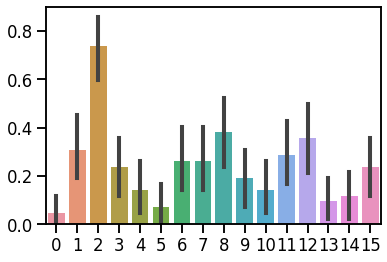

In [67]:
# how often was each segment predicted as abnormal motion by circle strain
import seaborn as sb
df = pd.DataFrame(r_segments, columns=list(range(r_segments.shape[1])))
sb.barplot(data=df)

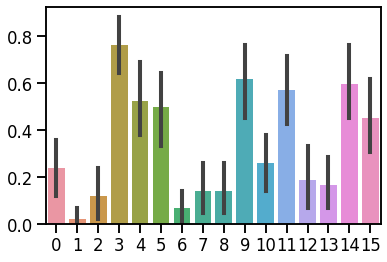

In [69]:
# how often was each segment predicted as abnormal motion by our strain
import seaborn as sb
df = pd.DataFrame(c_segments, columns=list(range(c_segments.shape[1])))
sb.barplot(data=df)

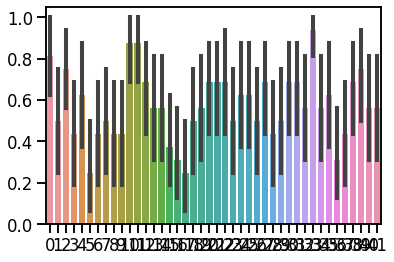

In [72]:
df = pd.DataFrame((mot_segments==lge_segments).T, columns=list(range(mot_segments.shape[0])))
sb.barplot(data=df)

In [132]:
tp, tn, fp, fn = get_scores(mot_segments, lge_segments)

TP: 52, FP: 23, TN: 678, FN: 159


In [133]:
acc = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp + fp) # PP=tp+fp
sensitivity = tp/(tp + fn) # P=tp+fn
print('acc: {:.4f}, prec: {:.4f}, sensitivity: {:.4f}'.format(acc, precision, sensitivity))

acc: 0.8004, prec: 0.6933, sensitivity: 0.2464


In [73]:
(lge_segments==0).sum(axis=1)

array([16, 16, 14,  8, 16, 16, 12, 16, 16, 16, 13, 16, 12, 12, 10,  9, 12,
        6, 16, 14,  9, 12, 16, 16, 16, 16, 15, 16,  8, 16, 15, 16, 11, 16,
        5, 14, 12, 11,  3, 13, 16, 10])

In [128]:
# Extract binary array from segments for all patients
lge_segments = df['LGE positive segments'].fillna(0).apply(extract_segments)
lge_segments = np.stack(lge_segments)
print(lge_segments.shape)

(57, 16)


In [129]:
# Extract binary array from segments for all patients
mot_segments = df['Strain positive segments'].fillna(0).apply(extract_segments)
mot_segments = np.stack(mot_segments)
print(mot_segments.shape)

(57, 16)


In [130]:
# True Positive segment predictions
tp  = mot_segments * lge_segments